In [1]:
import cvxpy as cp
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

# Set ERCOT load zone and solar capacity
ERCOT_LOAD_ZONE = 'LZ_HOUSTON'
SOLAR_CAPACITY = 300
SOLAR_PPA_DOL_KWH = 250
FACILITY_LIFETIME = 25

In [2]:
# READ IN DATA
# TODO: update as 'electricity' here is a normalised 8760 solar profile
hourly_dayahead_realtime_solar = pd.read_csv("hourly_dayahead_realtime_solar.csv")

# Filter by load zone and complete data
ERCOT_LOAD_ZONE = 'LZ_HOUSTON'
hourly_dayahead_realtime_solar_lz = hourly_dayahead_realtime_solar[hourly_dayahead_realtime_solar['zone'] == ERCOT_LOAD_ZONE]
hourly_dayahead_realtime_solar_lz = hourly_dayahead_realtime_solar_lz[hourly_dayahead_realtime_solar_lz['electricity'].notna()]

number_of_days_test = 100
hourly_dayahead_realtime_solar_lz = hourly_dayahead_realtime_solar_lz.iloc[0:24*number_of_days_test,]
# Sets time duration of the optimisation
# TODO: generat appropriate 8760 - due to shift in UTC time used for solar profile 
# and local_time used for ERCOT realtime and dayahead prices
T = hourly_dayahead_realtime_solar_lz.shape[0]
print(T)

2400


In [3]:
# FACILITY
FACILITY_LIFETIME = 25
OFFTAKE_TPD = 10
GREEN_THRESHOLD_kg_per_kg = 0.4
NUM_DAYS = math.ceil(T/24)
H2_SALES_PRICE_DOL_per_kg = 7

# POWER
#   SOLAR
SOLAR_CAPACITY = 400
SOLAR_PPA_DOL_KWH = 0.03 # 2 cents per kWh ($USD 50 per MWh)
hourly_solar_production_kwh = hourly_dayahead_realtime_solar_lz['electricity']/hourly_dayahead_realtime_solar_lz['electricity'].max()
#   GRID 
#       CONVERT $/MWh -> $/kWh
hourly_dayahead_dol_per_kwh = hourly_dayahead_realtime_solar_lz['price_dayahead'] / 1000
ERCTO_CO2_kg_per_kwh = 0.42062
hourly_dayahead_dol_per_kwh =  hourly_dayahead_dol_per_kwh.tolist()
hourly_dayahead_dol_per_kwh[23] = 1.15

# hourly_dayahead_dol_per_kwh

# EQUIPMENT
#   OPERATIONAL 
#       EFFICIENCY
ELECTROLYSIS_EFFICIENCY = 55
COMPRESSION_EFFICIENCY = 4
LIQUEFACTION_EFFICIENCY = 10
FUEL_CELL_EFFICIENCY = 20
#       LOWER OPERATION BOUNDS (% of nameplate capacity)
ELECTROLYSIS_OPERATION_LOWER = 0.15
COMPRESSOR_OPERATION_LOWER = 0.15
LIQUEFACTION_OPERATION_LOWER = 0.60 
#       RAMP CONSTRAINTS (% of nameplate capacity)
LIQUEFACTION_MAX_UP = 0.1 # 10% per hour up
LIQUEFACTION_MAX_DOWN = 0.1 # 10% per hour down

#   CAPEX
#   CAPEX - total
ELECTROLYSIS_CAPEX_DOL_TPD = 1900000 # 1.9 million $USD per TPD of electrolysis
COMPRESSOR_CAPEX_DOL_TPD = 900000 # 0.8 million $USD per TPD of comrpessor
LIQUEFACTION_CAPEX_DOL_TPD = 2945000 # 2.945 million $USD per TPD of liquefaction per day
#   CAPEX - annualised
ELECTROLYSIS_ANNUALISED_CAPEX_DOL_TPD = ELECTROLYSIS_CAPEX_DOL_TPD / FACILITY_LIFETIME
COMPRESSOR_ANNUALISED_CAPEX_DOL_TPD = COMPRESSOR_CAPEX_DOL_TPD / FACILITY_LIFETIME
LIQUEFACTION_ANNUALISED_CAPEX_DOL_TPD = LIQUEFACTION_CAPEX_DOL_TPD / FACILITY_LIFETIME
#   CAPEX - annualised
ELECTROLYSIS_ANNUALISED_CAPEX_DOL_kgPD = ELECTROLYSIS_ANNUALISED_CAPEX_DOL_TPD / 1000
COMPRESSOR_ANNUALISED_CAPEX_DOL_kgPD = COMPRESSOR_ANNUALISED_CAPEX_DOL_TPD / 1000
LIQUEFACTION_ANNUALISED_CAPEX_DOL_kgPD = LIQUEFACTION_ANNUALISED_CAPEX_DOL_TPD / 1000

#   CAPEX - daily, for fast testing 
ELECTROLYSIS_CAPEX_DOL_kgPD = ELECTROLYSIS_CAPEX_DOL_TPD / 1000
COMPRESSOR_CAPEX_DOL_kgPD = COMPRESSOR_CAPEX_DOL_TPD / 1000
LIQUEFACTION_CAPEX_DOL_kgPD = LIQUEFACTION_CAPEX_DOL_TPD / 1000

ELECTROLYSIS_CAPEX_DOL_kgPD = NUM_DAYS*ELECTROLYSIS_CAPEX_DOL_kgPD / (FACILITY_LIFETIME * 365)
COMPRESSOR_CAPEX_DOL_kgPD = NUM_DAYS*COMPRESSOR_CAPEX_DOL_kgPD / (FACILITY_LIFETIME * 365 )
LIQUEFACTION_CAPEX_DOL_kgPD = NUM_DAYS*LIQUEFACTION_CAPEX_DOL_kgPD / (FACILITY_LIFETIME * 365)
print(LIQUEFACTION_CAPEX_DOL_kgPD)
print(ELECTROLYSIS_CAPEX_DOL_kgPD)
print(len(hourly_dayahead_dol_per_kwh))
print(hourly_dayahead_dol_per_kwh)

32.273972602739725
20.82191780821918
2400
[0.0201, 0.019620000000000002, 0.01921, 0.018789999999999998, 0.02068, 0.02208, 0.0232, 0.02334, 0.02411, 0.02407, 0.024300000000000002, 0.02513, 0.02413, 0.022850000000000002, 0.02277, 0.02256, 0.02345, 0.03058, 0.03406, 0.0294, 0.02767, 0.02605, 0.02431, 1.15, 0.02281, 0.02233, 0.02231, 0.02191, 0.023579999999999997, 0.02687, 0.037450000000000004, 0.03717, 0.034820000000000004, 0.038009999999999995, 0.03943, 0.03667, 0.03395, 0.03419, 0.034210000000000004, 0.03372, 0.03554, 0.06263, 0.06436, 0.038729999999999994, 0.037939999999999995, 0.03354, 0.02938, 0.02478, 0.02509, 0.023100000000000002, 0.02368, 0.02314, 0.02258, 0.02798, 0.054090000000000006, 0.038880000000000005, 0.03445, 0.03445, 0.03263, 0.02969, 0.027739999999999997, 0.026260000000000002, 0.023690000000000003, 0.02431, 0.02698, 0.0412, 0.04358, 0.03357, 0.03271, 0.02852, 0.02619, 0.02286, 0.02142, 0.02162, 0.020489999999999998, 0.02124, 0.02232, 0.02721, 0.054299999999999994, 0.0455

In [4]:
prev_state_vector = {"realtime_price_$_per_kwh": 0,
        "realtime_production_kwh":0,
        "realtime_supplied_kwh": 0,
        "solar_production_kwh": 0, 
        "electrolyser_consumption_kwh": 0, 
        "compressor_consumption_kwh": 0, 
        "liquefaction_consumption_kwh": 0,
        "electrolyser_produced_kg": 0, 
        "compressor_produced_kg": 0, 
        "liquefaction_produced_kg": 0,
        "compress_to_liquefaction": 0,
        "fuel_cell_consumed_kg":0,
        "gh2_storage_level_kg": 0,
        # TODO: if problem size allows, add in big-M constraint 
        "gh2_storage_net_inflow": 0,
        "gh2_storge_inflow_kg": 0, 
        "gh2_storage_outflow_kg": 0
    }

hourly_solar_production_kwh = hourly_dayahead_realtime_solar_lz['electricity']/hourly_dayahead_realtime_solar_lz['electricity'].max()
#   GRID 
#       CONVERT $/MWh -> $/kWh
hourly_dayahead_dol_per_kwh = hourly_dayahead_realtime_solar_lz['price_dayahead'] / 1000
electrolyser_nameplate_capacity_hour = 1.5
compressor_nameplate_capacity_hour = 1.5
liquefaction_nameplate_capacity_hour = 1.5
fuelcell_nameplate_capacity_hour = 1
result_list = [ ]
t = 7
h = 24
hourly_solar_production_kwh = hourly_solar_production_kwh[t:t+h]
hourly_solar_production_kwh.insert(0,0)
hourly_dayahead_dol_per_kwh = hourly_dayahead_dol_per_kwh[t:t+h]
hourly_solar_production_kwh.insert(0,0)

T = h+1 
realtime_consumption = cp.Variable(T, nonneg = True)
realtime_supplied = cp.Variable(T, nonneg = True)
solar_consumed_facility = cp.Variable(T, nonneg = True) 

# set throughput
electrolyser_throughput = cp.Variable(T, nonneg = True)
compressor_throughput = cp.Variable(T, nonneg = True)
compressor_to_liquefaction = cp.Variable(T, nonneg = True)
liquefacion_throughput = cp.Variable(T, nonneg = True)
fuel_cell_throughput = cp.Variable(T, nonneg = True)

#   Operational decision variables
gh2_storage_inflow = cp.Variable(T,nonneg=True)
gh2_storage_outflow = cp.Variable(T,nonneg=True)
gh2_storage_level = cp.Variable(T+1, nonneg = True)
gh2_storage_active = cp.Variable(T, boolean=True)

# Define power balance constraints t
constraints = [
    # restrict the amount of solar that can be consumed
    solar_consumed_facility <= SOLAR_CAPACITY * hourly_solar_production_kwh,
    # power balance equation: sum of electricity in = amount consumed           
    realtime_consumption + solar_consumed_facility == 
        ELECTROLYSIS_EFFICIENCY*electrolyser_throughput + 
        COMPRESSION_EFFICIENCY*compressor_throughput + 
        LIQUEFACTION_EFFICIENCY*liquefacion_throughput, 
]

# add 'green' constraint; restrict amount that can be taken from grid
constraints += [ 
    sum(realtime_consumption) * ERCTO_CO2_kg_per_kwh <= GREEN_THRESHOLD_kg_per_kg * 1#(OFFTAKE_TPD * NUM_DAYS)
]

# operational constraints of equipment
constraints += [
    # constraint operational bounds of each piece of equipment: 
    0 <= electrolyser_throughput, 
    electrolyser_throughput <= electrolyser_nameplate_capacity_hour,
    0 <= compressor_throughput, 
    compressor_throughput <= compressor_nameplate_capacity_hour,
    0 <= liquefacion_throughput, 
    liquefacion_throughput <= liquefaction_nameplate_capacity_hour,
    0 <= fuel_cell_throughput, 
    fuel_cell_throughput <= fuelcell_nameplate_capacity_hour
    ]

# ramp constraints throughput constraints 
constraints += [ 
    liquefacion_throughput[1:T] - liquefacion_throughput[0:T-1] <= LIQUEFACTION_MAX_UP*liquefaction_nameplate_capacity_hour,
    liquefacion_throughput[0:T-1] - liquefacion_throughput[1:T] <= LIQUEFACTION_MAX_DOWN*liquefaction_nameplate_capacity_hour,
]

# add fuel cell offtake 
constraints += [ 
    fuel_cell_throughput*FUEL_CELL_EFFICIENCY == realtime_supplied, 

]

# set initial storage levels to empty
constraints += [ 
    gh2_storage_level[0] == prev_state_vector['gh2_storage_level_kg'],
    liquefacion_throughput[0] == prev_state_vector['liquefaction_consumption_kwh'] 
]

# balance mass through system
constraints += [
    electrolyser_throughput == compressor_throughput,
    compressor_throughput == compressor_to_liquefaction + gh2_storage_inflow,
    liquefacion_throughput == compressor_to_liquefaction + gh2_storage_outflow,
    # liquefacion_throughput == compressor_throughput + gh2_storage_netflow,
    gh2_storage_level[1:T+1] == gh2_storage_level[0:T] + gh2_storage_inflow  - gh2_storage_outflow - fuel_cell_throughput,
    # big-M constraint to only turn on storage if used 
    # TODO: remove if computational issues arise 
    compressor_throughput - liquefacion_throughput <= 1000 * gh2_storage_active,
    gh2_storage_inflow <= 1000*gh2_storage_active,
    gh2_storage_outflow <= 1000*gh2_storage_active
]

# Minimize total cost of supply; min(OPEX + CAPEX)
# OPEX = electricity, CAPEX = annualised capex
objective = 0

# PROFIT = REVENUES - COSTS

# REVENUES
# add electricity sales from dayahead market consumption
objective = objective +  realtime_supplied @ hourly_dayahead_dol_per_kwh  
# H2 SALES REVENUE 
objective = objective +  sum(liquefacion_throughput) * H2_SALES_PRICE_DOL_per_kg


# COSTS
# add electricity cost from dayahead market consumption
objective -= realtime_consumption @ hourly_dayahead_dol_per_kwh  
# add electricity cost from solar ppa consumption
objective -= cp.sum(SOLAR_PPA_DOL_KWH * solar_consumed_facility)


# Define profti maximiatio
objective_min = cp.Maximize(objective)
problem = cp.Problem(objective_min, constraints)

# Solve problem
problem.solve(solver="GUROBI", reoptimize=True)
print(problem.status)


operations_df = pd.DataFrame({
    "realtime_price_$_per_kwh": hourly_dayahead_dol_per_kwh,
    "realtime_production_kwh":realtime_consumption.value,
    "realtime_supplied_kwh": realtime_supplied.value,
    "solar_production_kwh": solar_consumed_facility.value, 
    "electrolyser_consumption_kwh": ELECTROLYSIS_EFFICIENCY*electrolyser_throughput.value, 
    "compressor_consumption_kwh": COMPRESSION_EFFICIENCY*compressor_throughput.value, 
    "liquefaction_consumption_kwh": LIQUEFACTION_EFFICIENCY*liquefacion_throughput.value,
    "electrolyser_produced_kg": electrolyser_throughput.value, 
    "compressor_produced_kg": compressor_throughput.value, 
    "liquefaction_produced_kg": liquefacion_throughput.value,
    "compress_to_liquefaction": compressor_to_liquefaction.value,
    "fuel_cell_consumed_kg": fuel_cell_throughput.value,
    "gh2_storage_level_kg": gh2_storage_level.value[0:T],
    # TODO: if problem size allows, add in big-M constraint 
    "gh2_storage_net_inflow": gh2_storage_inflow.value[0:T] - gh2_storage_outflow.value[0:T],
    "gh2_storge_inflow_kg": gh2_storage_inflow.value[0:T], 
    "gh2_storage_outflow_kg": gh2_storage_outflow.value[0:T]
    # "gh2_storage_netflow": gh2_storage_netflow.value
})
operations_df.reset_index().to_csv("operations_8760_df_t_new.csv")

AttributeError: 'Series' object has no attribute 'insert'

In [5]:
# Define decision variables
#   Electricity decision variables

def rolling_horizon_opt(prev_state_vector,
                    hourly_dayahead_dol_per_kwh,
                    hourly_solar_production_kwh,
                    electrolyser_nameplate_capacity_hour,
                    compressor_nameplate_capacity_hour,
                    liquefaction_nameplate_capacity_hour,
                    fuelcell_nameplate_capacity_hour,
                    ELECTROLYSIS_EFFICIENCY,
                    COMPRESSION_EFFICIENCY,
                    LIQUEFACTION_EFFICIENCY,
                    FUEL_CELL_EFFICIENCY, 
                    H2_SALES_PRICE_DOL_per_kg,
                    LIQUEFACTION_MAX_UP,
                    LIQUEFACTION_MAX_DOWN,
                    SOLAR_CAPACITY,
                    SOLAR_PPA_DOL_KWH,
                    ERCTO_CO2_kg_per_kwh,
                    GREEN_THRESHOLD_kg_per_kg,
                    NUM_DAYS, 
                    OFFTAKE_TPD,
                    T,
                    t):
    
    realtime_consumption = cp.Variable(T, nonneg = True)
    realtime_supplied = cp.Variable(T, nonneg = True)
    solar_consumed_facility = cp.Variable(T, nonneg = True) 

    # set throughput
    electrolyser_throughput = cp.Variable(T, nonneg = True)
    compressor_throughput = cp.Variable(T, nonneg = True)
    compressor_to_liquefaction = cp.Variable(T, nonneg = True)
    liquefacion_throughput = cp.Variable(T, nonneg = True)
    fuel_cell_throughput = cp.Variable(T, nonneg = True)

    #   Operational decision variables
    gh2_storage_inflow = cp.Variable(T,nonneg=True)
    gh2_storage_outflow = cp.Variable(T,nonneg=True)
    gh2_storage_level = cp.Variable(T+1, nonneg = True)
    gh2_storage_active = cp.Variable(T, boolean=True)

    # Define power balance constraints t
    constraints = [
        # restrict the amount of solar that can be consumed
        solar_consumed_facility <= SOLAR_CAPACITY * hourly_solar_production_kwh,
        # power balance equation: sum of electricity in = amount consumed           
        realtime_consumption + solar_consumed_facility == 
            ELECTROLYSIS_EFFICIENCY*electrolyser_throughput + 
            COMPRESSION_EFFICIENCY*compressor_throughput + 
            LIQUEFACTION_EFFICIENCY*liquefacion_throughput, 
    ]

    # add 'green' constraint; restrict amount that can be taken from grid
    constraints += [ 
        sum(realtime_consumption) * ERCTO_CO2_kg_per_kwh <= GREEN_THRESHOLD_kg_per_kg * 1#(OFFTAKE_TPD * NUM_DAYS)
    ]

    # operational constraints of equipment
    constraints += [
        # constraint operational bounds of each piece of equipment: 
        0 <= electrolyser_throughput, 
        electrolyser_throughput <= electrolyser_nameplate_capacity_hour,
        0 <= compressor_throughput, 
        compressor_throughput <= compressor_nameplate_capacity_hour,
        0 <= liquefacion_throughput, 
        liquefacion_throughput <= liquefaction_nameplate_capacity_hour,
        0 <= fuel_cell_throughput, 
        fuel_cell_throughput <= fuelcell_nameplate_capacity_hour
        ]

    # ramp constraints throughput constraints 
    constraints += [ 
        liquefacion_throughput[1:T] - liquefacion_throughput[0:T-1] <= LIQUEFACTION_MAX_UP*liquefaction_nameplate_capacity_hour,
        liquefacion_throughput[0:T-1] - liquefacion_throughput[1:T] <= LIQUEFACTION_MAX_DOWN*liquefaction_nameplate_capacity_hour,
    ]

    # add fuel cell offtake 
    constraints += [ 
        fuel_cell_throughput*FUEL_CELL_EFFICIENCY == realtime_supplied, 

    ]

    # set initial storage levels to empty
    constraints += [ 
        gh2_storage_level[0] == prev_state_vector['gh2_storage_level_kg'],
        liquefacion_throughput[0] == prev_state_vector['liquefaction_produced_kg'] 
    ]

    # balance mass through system
    constraints += [
        electrolyser_throughput == compressor_throughput,
        compressor_throughput == compressor_to_liquefaction + gh2_storage_inflow,
        liquefacion_throughput == compressor_to_liquefaction + gh2_storage_outflow,
        # liquefacion_throughput == compressor_throughput + gh2_storage_netflow,
        gh2_storage_level[1:T+1] == gh2_storage_level[0:T] + gh2_storage_inflow  - gh2_storage_outflow - fuel_cell_throughput,
        # big-M constraint to only turn on storage if used 
        # TODO: remove if computational issues arise 
        compressor_throughput - liquefacion_throughput <= 1000 * gh2_storage_active,
        gh2_storage_inflow <= 1000*gh2_storage_active,
        gh2_storage_outflow <= 1000*gh2_storage_active
    ]

    # Minimize total cost of supply; min(OPEX + CAPEX)
    # OPEX = electricity, CAPEX = annualised capex
    objective = 0

    # PROFIT = REVENUES - COSTS

    # REVENUES
    # add electricity sales from dayahead market consumption
    objective = objective +  realtime_supplied @ hourly_dayahead_dol_per_kwh  
    # H2 SALES REVENUE 
    objective = objective +  sum(liquefacion_throughput) * H2_SALES_PRICE_DOL_per_kg
    

    # COSTS
    # add electricity cost from dayahead market consumption
    objective -= realtime_consumption @ hourly_dayahead_dol_per_kwh  
    # add electricity cost from solar ppa consumption
    objective -= cp.sum(SOLAR_PPA_DOL_KWH * solar_consumed_facility)


    # Define profti maximiatio
    objective_min = cp.Maximize(objective)
    problem = cp.Problem(objective_min, constraints)
    

    # Solve problem
    problem.solve(solver="GUROBI", reoptimize=True)
    print(f"objective value {problem.value}")
    print(problem.status)

    # Check the problem status
    if problem.status == cp.settings.INFEASIBLE:
        print(problem.solver_stats.extra_stats)
        print("The problem is infeasible. Checking for IIS.")
        
        # Accessing the Gurobi model
        gurobi_data = problem.get_problem_data(cp.GUROBI)[0]
        print(gurobi_data)
        gurobi_model = gurobi_data['model']
        
        # Compute the IIS
        gurobi_model.computeIIS()
        
        # Print the IIS
        print("The following constraint(s) cannot be satisfied:")
        for c in gurobi_model.getConstrs():
            if c.IISConstr:
                print(f"{c.constrName} is part of the IIS.")
    operations_df = pd.DataFrame({
        "realtime_price_$_per_kwh": hourly_dayahead_dol_per_kwh,
        "realtime_production_kwh":realtime_consumption.value,
        "realtime_supplied_kwh": realtime_supplied.value,
        "solar_production_kwh": solar_consumed_facility.value, 
        "electrolyser_consumption_kwh": ELECTROLYSIS_EFFICIENCY*electrolyser_throughput.value, 
        "compressor_consumption_kwh": COMPRESSION_EFFICIENCY*compressor_throughput.value, 
        "liquefaction_consumption_kwh": LIQUEFACTION_EFFICIENCY*liquefacion_throughput.value,
        "electrolyser_produced_kg": electrolyser_throughput.value, 
        "compressor_produced_kg": compressor_throughput.value, 
        "liquefaction_produced_kg": liquefacion_throughput.value,
        "compress_to_liquefaction": compressor_to_liquefaction.value,
        "fuel_cell_consumed_kg": fuel_cell_throughput.value,
        "gh2_storage_level_kg": gh2_storage_level.value[0:T],
        # TODO: if problem size allows, add in big-M constraint 
        "gh2_storage_net_inflow": gh2_storage_inflow.value[0:T] - gh2_storage_outflow.value[0:T],
        "gh2_storge_inflow_kg": gh2_storage_inflow.value[0:T], 
        "gh2_storage_outflow_kg": gh2_storage_outflow.value[0:T]
        # "gh2_storage_netflow": gh2_storage_netflow.value
    })
    operations_df.reset_index().to_csv(f"operations_8760_df_t_loop_{t}.csv")
    try:
        return {"realtime_price_$_per_kwh": hourly_dayahead_dol_per_kwh.tolist()[1],
            "realtime_production_kwh":realtime_consumption.value[1],
            "realtime_supplied_kwh": realtime_supplied.value[1],
            "solar_production_kwh": solar_consumed_facility.value[1], 
            "electrolyser_consumption_kwh": ELECTROLYSIS_EFFICIENCY*electrolyser_throughput.value[1], 
            "compressor_consumption_kwh": COMPRESSION_EFFICIENCY*compressor_throughput.value[1], 
            "liquefaction_consumption_kwh": LIQUEFACTION_EFFICIENCY*liquefacion_throughput.value[1],
            "electrolyser_produced_kg": electrolyser_throughput.value[1], 
            "compressor_produced_kg": compressor_throughput.value[1], 
            "liquefaction_produced_kg": liquefacion_throughput.value[1],
            "compress_to_liquefaction": compressor_to_liquefaction.value[1],
            "fuel_cell_consumed_kg": fuel_cell_throughput.value[1],
            "gh2_storage_level_kg": gh2_storage_level.value[1],
            # TODO: if problem size allows, add in big-M constraint 
            "gh2_storage_net_inflow": gh2_storage_inflow.value[1] - gh2_storage_outflow.value[1],
            "gh2_storge_inflow_kg": gh2_storage_inflow.value[1], 
            "gh2_storage_outflow_kg": gh2_storage_outflow.value[1]
        }

    except:
        print(problem.solver_stats.extra_stats)
        gurobi_data = problem.get_problem_data(cp.GUROBI)[0]
        gurobi_model = gurobi_data['model']
        
        # Compute the IIS
        gurobi_model.computeIIS()
        
        # Print the IIS
        print("The following constraint(s) cannot be satisfied:")
        for c in gurobi_model.getConstrs():
            if c.IISConstr:
                print(f"{c.constrName} is part of the IIS.")


In [8]:
intial_state = {"realtime_price_$_per_kwh": 0,
        "realtime_production_kwh":0,
        "realtime_supplied_kwh": 0,
        "solar_production_kwh": 0, 
        "electrolyser_consumption_kwh": 0, 
        "compressor_consumption_kwh": 0, 
        "liquefaction_consumption_kwh": 0,
        "electrolyser_produced_kg": 0, 
        "compressor_produced_kg": 0, 
        "liquefaction_produced_kg": 0,
        "compress_to_liquefaction": 0,
        "fuel_cell_consumed_kg":0,
        "gh2_storage_level_kg": 0,
        # TODO: if problem size allows, add in big-M constraint 
        "gh2_storage_net_inflow": 0,
        "gh2_storge_inflow_kg": 0, 
        "gh2_storage_outflow_kg": 0
    }

h = 6
t = 0 

prev_state_vector = intial_state

hourly_solar_production_kwh = hourly_dayahead_realtime_solar_lz['electricity']/hourly_dayahead_realtime_solar_lz['electricity'].max()
#   GRID 
#       CONVERT $/MWh -> $/kWh
hourly_dayahead_dol_per_kwh = hourly_dayahead_realtime_solar_lz['price_dayahead'] / 1000
electrolyser_nameplate_capacity_hour = 1.5
compressor_nameplate_capacity_hour = 1.5
liquefaction_nameplate_capacity_hour = 1.5
fuelcell_nameplate_capacity_hour = 1
result_list = [ ]
for t in range(24):
    solar_consumed_facility = hourly_solar_production_kwh[t:t+h]
    print(t)
    hourly_dayahead_dol_per_kwh_h = hourly_dayahead_dol_per_kwh[t:t+h]
    T=h
    try:
        result_dict_t = rolling_horizon_opt(prev_state_vector,
                        hourly_dayahead_dol_per_kwh_h,
                        solar_consumed_facility,
                        electrolyser_nameplate_capacity_hour,
                        compressor_nameplate_capacity_hour,
                        liquefaction_nameplate_capacity_hour,
                        fuelcell_nameplate_capacity_hour,
                        ELECTROLYSIS_EFFICIENCY,
                        COMPRESSION_EFFICIENCY,
                        LIQUEFACTION_EFFICIENCY,
                        FUEL_CELL_EFFICIENCY, 
                        H2_SALES_PRICE_DOL_per_kg,
                        LIQUEFACTION_MAX_UP,
                        LIQUEFACTION_MAX_DOWN,
                        SOLAR_CAPACITY,
                        SOLAR_PPA_DOL_KWH,
                        ERCTO_CO2_kg_per_kwh,
                        GREEN_THRESHOLD_kg_per_kg,
                        NUM_DAYS, 
                        OFFTAKE_TPD,
                        T,
                        t)
    except:
        print(f"failed on {result_dict_t}")
    result_list.append(result_dict_t)
    prev_state_vector = result_dict_t


0
objective value 0.07860708036928235
optimal
1
objective value 0.07860708036928235
optimal
2


objective value 0.3051732989587419
optimal
3
objective value 1.2712395175482014
optimal
4
objective value 3.1109016428702354
optimal
5
objective value 5.922898941115054
optimal
6
objective value 9.610555766462378
optimal
7
objective value 13.766858042383374
optimal
8
objective value 18.147265393436584
optimal
9
objective value 23.234686146078438
optimal
10
objective value 27.302066140809366
optimal
11
objective value 33.443039001871675
optimal
12
objective value 17.31801315509935
optimal
13
objective value 12.633075911749353
optimal
14
objective value 7.97592123531932
optimal
15
objective value 4.323766558889276
optimal
16
objective value 2.278757786125263
optimal
17
objective value 0.6366031096952214
optimal
18
objective value 0.07452738848587216
optimal
19
objective value 0.07478415231070218
optimal
20
objective value 0.07524062133262219
optimal
21
objective value 0.07525964087520219
optimal
22
objective value 0.07564003172680221
optimal
23
objective value 0.07564003172680221
optimal

In [9]:
result_df = pd.DataFrame(result_list)
# profit = realtime_supplied_kwh * realtime_price_$_per_kwh + liquefaction_produced_kg * H2_SALES_PRICE_DOL_per_kg - realtime_price_$_per_kwh * realtime_production_kwh  -  solar_production_kwh * SOLAR_PPA_DOL_KWH


,realtime_price_$_per_kwh,realtime_production_kwh,realtime_supplied_kwh,solar_production_kwh,electrolyser_consumption_kwh,compressor_consumption_kwh,liquefaction_consumption_kwh,electrolyser_produced_kg,compressor_produced_kg,liquefaction_produced_kg,compress_to_liquefaction,fuel_cell_consumed_kg,gh2_storage_level_kg,gh2_storage_net_inflow,gh2_storge_inflow_kg,gh2_storage_outflow_kg
0,0.01962,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
1,0.01921,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
2,0.01879,0.950977,0.0,0.000000,0.758025,0.055129,0.137823,0.013782,0.013782,0.013782,0.000000,0.0,0.000000,0.000000,0.013782,0.013782
3,0.02068,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
4,0.02208,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.016118,0.000000,0.000000,0.000000
5,0.02320,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.032237,0.000000,0.000000,0.000000
6,0.02334,0.000000,0.0,3.171008,2.142178,0.155795,0.873035,0.038949,0.038949,0.087303,0.000000,0.0,0.048355,-0.048355,0.038949,0.087303
7,0.02411,0.000000,0.0,38.052095,33.260141,2.418919,2.373035,0.604730,0.604730,0.237303,0.000000,0.0,0.016118,0.367426,0.604730,0.237303
8,0.02407,0.000000,0.0,4.094806,0.206736,0.015035,3.873035,0.003759,0.003759,0.387303,0.000000,0.0,0.383545,-0.383545,0.003759,0.387303
9,0.02430,0.000000,0.0,37.073939,29.551691,2.149214,5.373035,0.537303,0.537303,0.537303,0.537303,0.0,0.174607,0.000000,0.000000,0.000000


In [15]:
result_df = pd.DataFrame(result_list)

def calculate_profit(result_df, H2_SALES_PRICE_DOL_per_kg, SOLAR_PPA_DOL_KWH):
    profit = sum(result_df['realtime_supplied_kwh'] * result_df['realtime_price_$_per_kwh']) + \
    sum(result_df['liquefaction_produced_kg']) * H2_SALES_PRICE_DOL_per_kg - \
    sum(result_df['realtime_production_kwh'] * result_df['realtime_price_$_per_kwh']) - \
    sum(result_df['solar_production_kwh'] * SOLAR_PPA_DOL_KWH)

    return profit

calculate_profit(result_df,H2_SALES_PRICE_DOL_per_kg, SOLAR_PPA_DOL_KWH )


28.663863318863452

In [10]:

# create dataframe of results: 
operations_df = pd.DataFrame({
    "realtime_price_$_per_kwh": hourly_dayahead_dol_per_kwh,
    "realtime_production_kwh":realtime_consumption.value,
    "realtime_supplied_kwh": realtime_supplied.value,
    "solar_production_kwh": solar_consumed_facility.value, 
    "electrolyser_consumption_kwh": ELECTROLYSIS_EFFICIENCY*electrolyser_throughput.value, 
    "compressor_consumption_kwh": COMPRESSION_EFFICIENCY*compressor_throughput.value, 
    "liquefaction_consumption_kwh": LIQUEFACTION_EFFICIENCY*liquefacion_throughput.value,
    "electrolyser_produced_kg": electrolyser_throughput.value, 
    "compressor_produced_kg": compressor_throughput.value, 
    "liquefaction_produced_kg": liquefacion_throughput.value,
    "compress_to_liquefaction": compressor_to_liquefaction.value,
    "fuel_cell_consumed_kg": fuel_cell_throughput.value,
    "gh2_storage_level_kg": gh2_storage_level.value[0:T],
    # TODO: if problem size allows, add in big-M constraint 
    "gh2_storage_net_inflow": gh2_storage_inflow.value[0:T] - gh2_storage_outflow.value[0:T],
    "gh2_storge_inflow_kg": gh2_storage_inflow.value[0:T], 
    "gh2_storage_outflow_kg": gh2_storage_outflow.value[0:T]
    # "gh2_storage_netflow": gh2_storage_netflow.value
})
operations_df.reset_index().to_csv("operations_8760_df.csv")

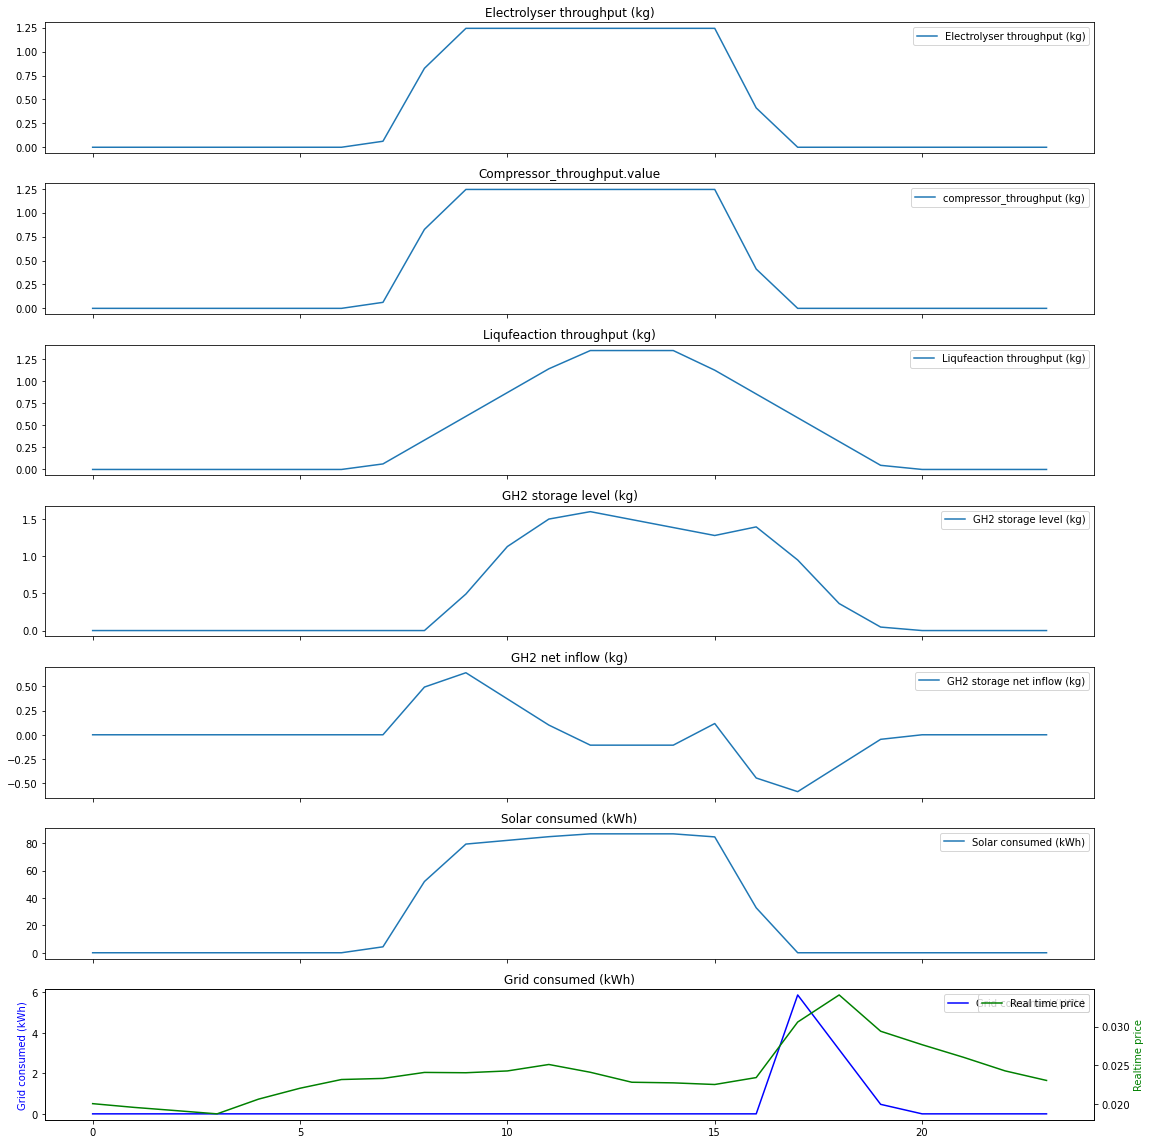

In [53]:
fig, axs = plt.subplots(7, 1, figsize=(16, 16), sharex=True)  # 'sharex=True' shares the x-axis among all plots

t = range(24)
# Plot each time series in a different subplot
axs[0].plot(t, electrolyser_throughput.value, label='Electrolyser throughput (kg)')
axs[0].set_title('Electrolyser throughput (kg)')
axs[0].legend()

axs[1].plot(t, compressor_throughput.value, label='compressor_throughput (kg)')
axs[1].set_title('Compressor_throughput.value')
axs[1].legend()

axs[2].plot(t, liquefacion_throughput.value, label='Liqufeaction throughput (kg)')
axs[2].set_title('Liqufeaction throughput (kg)')
axs[2].legend()

axs[3].plot(t, gh2_storage_level.value[0:T], label='GH2 storage level (kg)')
axs[3].set_title('GH2 storage level (kg)')
axs[3].legend()

axs[4].plot(t, operations_df['gh2_storage_net_inflow'].to_list(), label='GH2 storage net inflow (kg)')
axs[4].set_title('GH2 net inflow (kg)')
axs[4].legend()

axs[5].plot(t, operations_df['solar_production_kwh'].to_list(), label='Solar consumed (kWh)')
axs[5].set_title('Solar consumed (kWh)')
axs[5].legend()



axs6 = axs[6]
axs6.plot(t, operations_df['realtime_production_kwh'].to_list(), label='Grid consumed (kWh)', color='blue')
axs6.set_title('Grid consumed (kWh)')
axs6.set_ylabel('Grid consumed (kWh)', color='blue')
axs6.legend()

# Create a secondary y-axis for the fourth subplot
axs3_right = axs6.twinx()
axs3_right.plot(t, operations_df['realtime_price_$_per_kwh'].to_list(), label='Real time price', color='green')
axs3_right.set_ylabel('Realtime price', color='green')
axs3_right.legend()
# Optionally, adjust spacing between subplots for better visibility
plt.tight_layout()

# Show plot
plt.show()

In [45]:
operations_df['gh2_storage_net_inflow']

2      0.000000
10     0.000000
18     0.000000
26     0.000000
34    -0.000000
42    -0.000000
50     0.000000
58     0.000000
66     0.492302
74     0.640130
82     0.370098
90     0.100066
98    -0.107149
106   -0.107149
114   -0.107149
122    0.115922
130   -0.446094
138   -0.587024
146   -0.316992
154   -0.046961
162    0.000000
170    0.000000
178    0.000000
186    0.000000
Name: gh2_storage_net_inflow, dtype: float64